In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
import cv2
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Correct path
zip_path = '/content/drive/MyDrive/Brain.zip'
data_dir = '/content/Brain'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(data_dir)


In [ ]:

# Assuming that the dataset has a structure like /content/brain/Training and /content/brain/Testing
training_data_directory = os.path.join(data_dir, 'Training')
test_data_directory = os.path.join(data_dir, 'Testing')

# Set random seed for reproducibility
np.random.seed(42)



In [ ]:
# Initiate data processing tools
training_data_processor = ImageDataGenerator(
    rescale=1. / 255,  # rescaling factor should be 255, not 256
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10,
    shear_range=0.2,
    height_shift_range=0.1,
    width_shift_range=0.1
)
test_data_processor = ImageDataGenerator(rescale=1. / 255)



In [ ]:
# Load data into Python
training_data = training_data_processor.flow_from_directory(
    training_data_directory,
    target_size=(224, 224),  # VGG16 default input size is 224x224
    batch_size=15,
    class_mode='categorical',
    shuffle=True
)
testing_data = test_data_processor.flow_from_directory(
    test_data_directory,
    target_size=(224, 224),  # VGG16 default input size is 224x224
    batch_size=4,
    class_mode='categorical',
    shuffle=False
)



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# VGG16 model for transfer learning
model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

for layer in model.layers:
    layer.trainable = False

last_layer = model.get_layer('block5_pool')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(128, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.30)(x)
# Add a final softmax layer for classification
x = Dense(4, activation='softmax')(x)  # Adjust the number of neurons according to the number of classes in your dataset
model = Model(model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
hist = model.fit(training_data, epochs=5, shuffle=False, validation_data=testing_data)


58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/5
381/381 [==============================] - 244s 638ms/step - loss: 0.8690 - accuracy: 0.6306 - val_loss: 0.5721 - val_accuracy: 0.7864
Epoch 2/5
381/381 [==============================] - 243s 637ms/step - loss: 0.5734 - accuracy: 0.7834 - val_loss: 0.5238 - val_accuracy: 0.8108
Epoch 3/5
381/381 [==============================] - 244s 641ms/step - loss: 0.5130 - accuracy: 0.8107 - val_loss: 0.5711 - val_accuracy: 0.8055
Epoch 4/5
381/381 [==============================] - 244s 639ms/step - loss: 0.4828 - accuracy: 0.8116 - val_loss: 0.5419 - val_accuracy: 0.7986
Epoch 5/5
381/381 [==============================] - 243s 639ms/step - loss: 0.4476 - accuracy: 0.8318 - val_loss: 0.4919 - val_accuracy: 0.8093


In [ ]:
# Save and reload the model
model.save('/content/drive/MyDrive/brain_model.h5')
model = tf.keras.models.load_model('/content/drive/MyDrive/brain_model.h5')




In [ ]:

def make_prediction(image_fp):
    img = image.load_img(image_fp, target_size=(224, 224))  # Match input size of VGG16
    img_array = image.img_to_array(img) / 255.  # Match scaling used earlier
    img_batch = np.expand_dims(img_array, axis=0)
    class_labels = list(training_data.class_indices.keys())  # Get labels from training data
    predicted_value = class_labels[np.argmax(model.predict(img_batch, verbose=0))]  # Add verbose=0
    true_value = re.search(r'(glioma)|(meningioma)|(notumor)|(pituitary)', image_fp)[0]
    correct = (predicted_value == true_value)
    return predicted_value, true_value, correct




+----------------------------------------------------+------------+------------+---------+
|                       Image                        | Predicted  |   Actual   | Correct |
+----------------------------------------------------+------------+------------+---------+
|   /content/Brain/Testing/notumor/Te-no_0236.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0085.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0073.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0201.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0384.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0339.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0132.jpg    |  notumor   |  notumor   |   True  |
|   /content/Brain/Testing/notumor/Te-no_0156.jpg    |  notumor   |  notumor   |   True  |

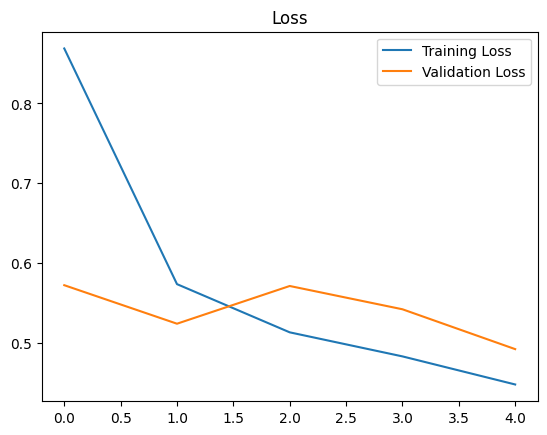

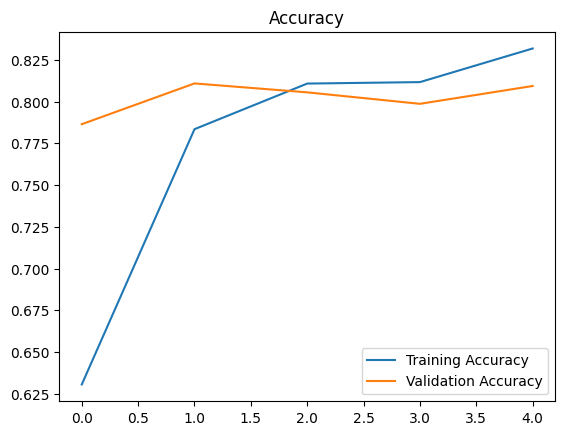

In [ ]:
# Import the PrettyTable library
from prettytable import PrettyTable
from glob import glob

# Get the list of all image files in the test directory
test_images = glob(os.path.join(test_data_directory, '*/*.jpg'))  # Update the file pattern if needed

# Initialize a PrettyTable object
results_table = PrettyTable()

# Add column names
results_table.field_names = ["Image", "Predicted", "Actual", "Correct"]

# Loop through each file
for test_image in test_images:
    pred, actual, correct = make_prediction(test_image)
    results_table.add_row([test_image, pred, actual, correct])

# Then, at the end, print out the table
print(results_table)

# Performance plots
plt.figure()
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.figure()
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


328/328 [==============================] - 48s 147ms/step
Classification report:
               precision    recall  f1-score   support

      glioma       0.89      0.72      0.80       300
  meningioma       0.74      0.53      0.62       306
     notumor       0.93      0.95      0.94       405
   pituitary       0.68      0.99      0.81       300

    accuracy                           0.81      1311
   macro avg       0.81      0.80      0.79      1311
weighted avg       0.82      0.81      0.80      1311



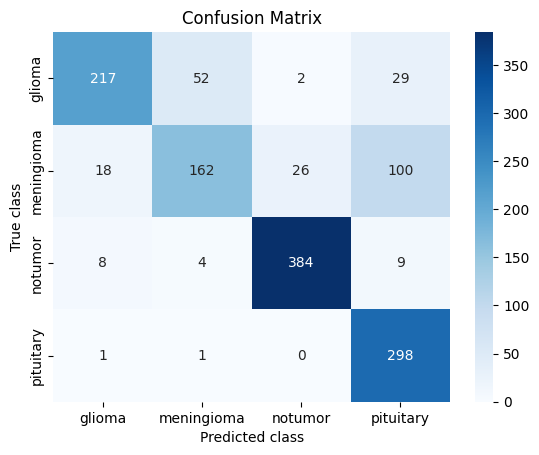

328/328 [==============================] - 48s 147ms/step - loss: 0.4919 - accuracy: 0.8093


In [ ]:

# Confusion matrix and classification report
y_pred = np.argmax(model.predict(testing_data), axis=1)
cm = confusion_matrix(testing_data.classes, y_pred)
cr = classification_report(testing_data.classes, y_pred, target_names=list(training_data.class_indices.keys()))

print("Classification report:\n", cr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(training_data.class_indices.keys()), yticklabels=list(training_data.class_indices.keys()))
plt.title("Confusion Matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

_, accuracy = model.evaluate(testing_data)
